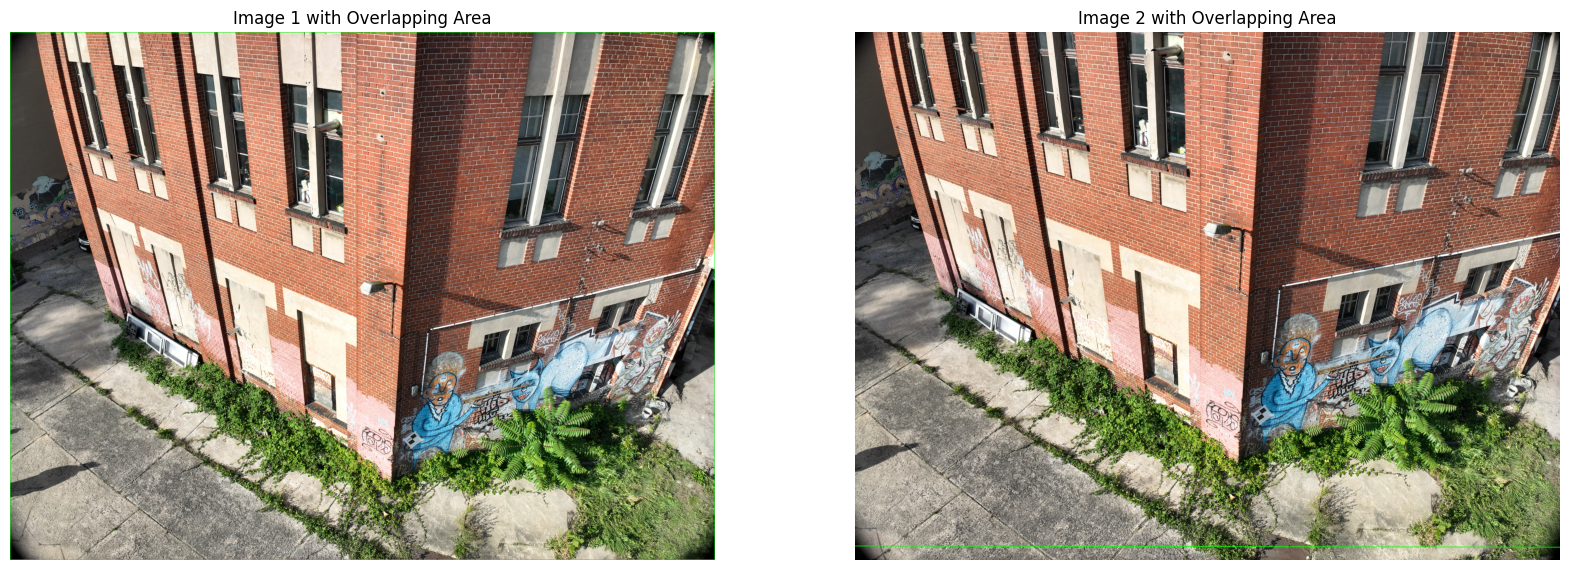

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def find_overlap(img1, img2):
    # Convert images to grayscale
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Find keypoints and descriptors using SIFT
    kp1, des1 = sift.detectAndCompute(gray1, None)
    kp2, des2 = sift.detectAndCompute(gray2, None)

    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    # FLANN-based matcher
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    # Store good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    # Extract coordinates of good matches
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # Find homography
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    # Compute the corner points of the overlapping area
    h, w = img1.shape[:2]
    pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)
    dst = cv2.perspectiveTransform(pts, M)

    # Draw overlapping area
    img2_with_overlap = img2.copy()
    cv2.polylines(img2_with_overlap, [np.int32(dst)], True, (0, 255, 0), 3, cv2.LINE_AA)

    # Draw overlapping area on img1
    img1_with_overlap = img1.copy()
    cv2.polylines(img1_with_overlap, [np.int32(pts)], True, (0, 255, 0), 3, cv2.LINE_AA)

    return img1_with_overlap, img2_with_overlap

# Load images
img1 = cv2.imread('image1.jpg')
img2 = cv2.imread('image2.jpg')

# Find and draw overlapping area
result1, result2 = find_overlap(img1, img2)

# Show results
plt.figure(figsize=(20,10))
plt.subplot(121), plt.imshow(cv2.cvtColor(result1, cv2.COLOR_BGR2RGB))
plt.title('Image 1 with Overlapping Area'), plt.axis('off')
plt.subplot(122), plt.imshow(cv2.cvtColor(result2, cv2.COLOR_BGR2RGB))
plt.title('Image 2 with Overlapping Area'), plt.axis('off')
plt.show()
